<a href="https://colab.research.google.com/github/mistecon/utility/blob/main/histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!apt-get -y update
!apt-get -y install gnuplot
!pip -q install PyGnuplot gnuplotlib

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,580 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,738 kB]
Ge

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import subprocess, textwrap


In [82]:
def gnuhist(counts_densities, widths, centers, outfpath:Path, logxy_flg=False):
    outfpath = str(outfpath).replace('\\','/')
    logscale = {True:"set logscale xy", False:""}[logxy_flg]
    data_block = "\n".join(f"{x} {y} {w}" for x,y,w in zip(centers, counts_densities, widths))
    print(outfpath, logscale)
    xmin = {True:centers[0]/2, False:(centers[0]-widths[0])/1.1}[logxy_flg]
    xmax = {True:centers[-1]*2, False:(centers[-1]+widths[-1])*1.1}[logxy_flg]

    ymin = {True:counts_densities[counts_densities!=0].min()/2, False:0}[logxy_flg]
    print("cd",counts_densities)
    print("ymin",ymin)
    ymax = {True:counts_densities.max()*2, False:counts_densities.max()*1.1}[logxy_flg]

    script = textwrap.dedent(f"""
        set term pngcairo size 800,500
        set output '{outfpath}'
        {logscale}
        set xrange [{xmin}:{xmax}]
        set yrange [{ymin}:{ymax}]
        set style fill solid 0.5
        set boxwidth 0.9 relative
        plot '-' using 1:2:(0.9*$3) with boxes notitle
        {data_block}
        e
    """)
    subprocess.run(["gnuplot"], input=script.encode("utf-8"), check=True)

gnuhist(np.array([1,2,3]),np.array([1,1,1]),np.array([1,2,3]),"test.png", False)

test.png 
cd [1 2 3]
ymin 0


test.png 
cd [2.25013501e-04 6.75040502e-04 1.35008100e-03 4.01274076e-03
 8.70052203e-03 1.71760306e-02 3.06018361e-02 5.50158009e-02
 8.54301258e-02 1.39958398e-01 1.94336660e-01 2.57377943e-01
 3.18094086e-01 3.69809689e-01 3.93023581e-01 3.95273716e-01
 3.71609797e-01 3.17381543e-01 2.56290377e-01 1.93361602e-01
 1.35158109e-01 8.91428486e-02 5.54658279e-02 2.97392844e-02
 1.67260036e-02 8.10048603e-03 3.30019801e-03 2.02512151e-03
 4.12524751e-04 2.25013501e-04]
ymin 0


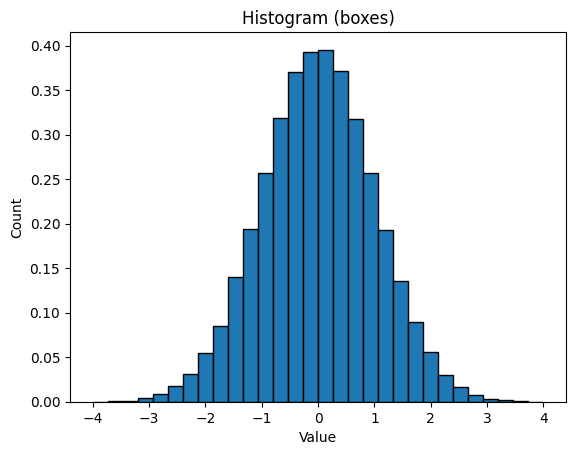

In [83]:
def func_hist(data, xmin=None, xmax=None, binno=20, density_flg=True):
    """
    等幅ヒストグラム（集計区間は [xmin, xmax)）
    density_flg=True: 確率密度（PDF）を返す。面積=1 になるように height = counts / (N*width)。
    戻り値:
        densities_or_counts (binno,), widths (binno,), centers (binno,)
    """
    if xmin is None:
        xmin = data.min()
    if xmax is None:
        xmax = data.max()

    bins = np.linspace(xmin, xmax, binno+1)
    #データをxmin, xmaxに含まれる範囲に絞る
    data_clip = data[(data>=xmin)&(data<xmax)]
    data_dg = np.digitize(data_clip, bins, right=True) #right=Trueはビンの左端を含み、右端を含まない
    counts = pd.Series(data_dg).value_counts().reindex(index=np.arange(1, binno+1)).fillna(0).to_numpy()
    widths = bins[1:] - bins[:-1]
    if counts.sum()>0:
        densities = counts/(widths*counts.sum())
    else:
        densities = np.zeros(binno)
    #print((densities*widths).sum())
    centers = (bins[1:] + bins[:-1])/2
    if density_flg == True:
        return densities, widths, centers
    else:
        return counts, widths, centers

# 乱数生成
generator = np.random.default_rng()
data = generator.normal(size=100000)

# ヒストグラム作成
counts_densities, widths, centers = func_hist(data, -4, 4, 30, True)

#gnuplotで描画
gnuhist(counts_densities, widths, centers, "test.png", logxy_flg=False)

# 棒グラフとして描画
# 棒の中心を合わせるために bins の中央値を使う
plt.bar(centers, counts_densities, width=widths, align='center', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram (boxes)')
plt.show()


0.9999999999999999
test.png set logscale xy
cd [1.70327044e+00 7.52988530e-01 3.34552461e-01 1.47573444e-01
 6.67905686e-02 2.94213180e-02 1.42122536e-02 5.76403915e-03
 2.90749472e-03 1.13773517e-03 5.56144718e-04 2.30084089e-04
 1.04783712e-04 4.64554387e-05 2.76756500e-05 8.54915841e-06
 3.88047881e-06 4.62356082e-06 6.12104151e-07 0.00000000e+00
 3.86211609e-07 6.13557572e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
ymin 1.931058046930811e-07


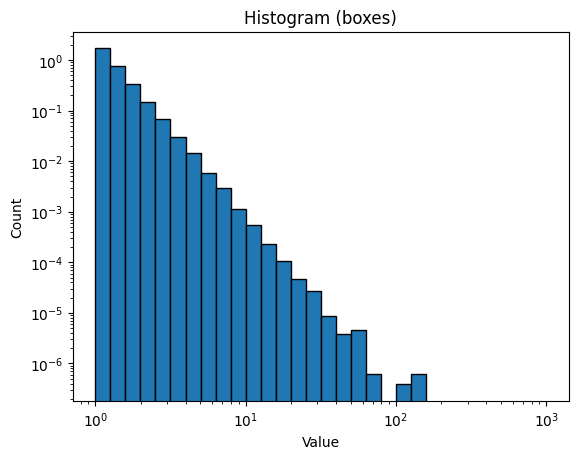

In [84]:
def func_hist_log(data, xmin=None, xmax=None, binno=20, density_flg=True):
    """
    data : numpy array (size n)
    """
    if xmin is None:
        xmin = data.min()
    if xmax is None:
        xmax = data.max()
    if xmin<=0:
        print("xmin should be positive")
        return None, None, None

    logbins = np.linspace(np.log(xmin), np.log(xmax), binno+1)

    #データをxmin, xmaxに含まれる範囲に絞る
    data_clip = data[(data>=xmin)&(data<xmax)]
    #データを何番目のbinかの数字に変換
    data_dg = np.digitize(data_clip, np.exp(logbins), right=True) #right=Trueはビンの左端を含み、右端を含まない
    counts = pd.Series(data_dg).value_counts().reindex(index=np.arange(1, binno+1)).fillna(0).to_numpy()
    widths = np.exp(logbins[1:]) - np.exp(logbins[:-1])
    if counts.sum()>0:
        densities = counts/(widths*counts.sum())
    else:
        densities = np.zeros(binno)
    print((densities*widths).sum())
    centers = (np.exp(logbins[1:]) + np.exp(logbins[:-1]))/2
    if density_flg == True:
        return densities, widths, centers
    else:
        return counts, widths, centers

# 乱数生成(べき分布)
alpha = 2.5          # 指数（tail exponent）
xm = 1.0          # 下限
n = 100_000

# numpy の Pareto は「1+Pareto(alpha)」が x>=1 のべき分布
x = xm * (1 + np.random.pareto(alpha, size=n))

# ヒストグラム作成
counts_densities, widths, centers = func_hist_log(x, 1, 10**3, 30, True)

#gnuplotで描画
gnuhist(counts_densities, widths, centers, "test.png", logxy_flg=True)

# 棒グラフとして描画
# 棒の中心を合わせるために bins の中央値を使う
plt.bar(centers, counts_densities, width=widths, align='center', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Histogram (boxes)')
plt.show()


In [8]:
centers

array([-3.86206897, -3.5862069 , -3.31034483, -3.03448276, -2.75862069,
       -2.48275862, -2.20689655, -1.93103448, -1.65517241, -1.37931034,
       -1.10344828, -0.82758621, -0.55172414, -0.27586207,  0.        ,
        0.27586207,  0.55172414,  0.82758621,  1.10344828,  1.37931034,
        1.65517241,  1.93103448,  2.20689655,  2.48275862,  2.75862069,
        3.03448276,  3.31034483,  3.5862069 ,  3.86206897])